In [1]:
from lmfit import Parameters
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.signal import wiener, filtfilt, butter, gaussian, freqz
from scipy.ndimage import filters
from core.util.units import compute_dft

In [2]:
def lorentzianpeak_testing2():
    """ Test the lorentzian fit directy with simulated data. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model',mod.param_names)
    params = Parameters()

    params.add('amplitude',value=10.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=10.)

    data_nice = mod.eval(x=x_axis,params=params)
    data_noisy = data_nice + 5.0*np.random.normal(size=x_axis.shape)

    result = fitlogic.make_lorentzian_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentzian_peak)

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy simulated data')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']


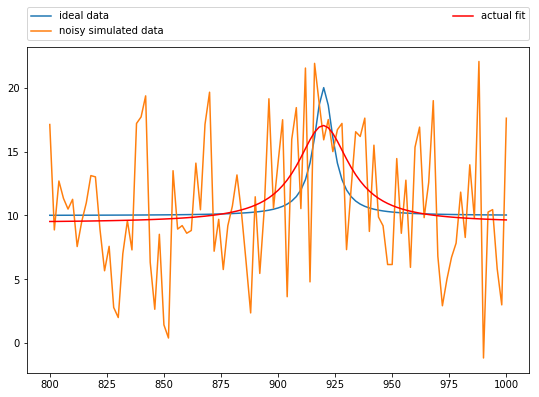

In [3]:
lorentzianpeak_testing2()

In [4]:
def lorentziandip_testing():
    """ Test the lorentzian estimator. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model', mod.param_names)
    params = Parameters()

    params.add('amplitude',value=-20.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=10.)

    data_nice = mod.eval(x=x_axis, params=params)
    data_noisy= data_nice + 6.0*np.random.normal(size=x_axis.shape)

    data_smooth, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)
    print('offset',offset)

    plt.figure()
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, data_smooth, label='convoluted smooth data')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
               ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    data_level = data_smooth - offset

    amplitude = data_level.min()
    print('amplitude', amplitude)

    data_min = data_smooth.min()
    data_max = data_smooth.max()
    print('data_min', data_min)

    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(x_axis, data_level, k=smoothing_spline)
    numerical_integral = abs(function.integral(x_axis[0], x_axis[-1]))

    if data_max > abs(data_min):
        fitlogic.log.warning('The lorentzian estimator set the peak to the minimal value, if '
                             'you want to fit a peak instead of a dip rewrite the estimator.')

    amplitude_median = data_min
    x_zero = x_axis[np.argmin(data_smooth)]

    # For the fitting procedure it is much better to start with a larger sigma
    # then with a smaller one. A small sigma is prone to larger instabilities
    # in the fit.
    oversize_sigma = 1

    sigma = abs((numerical_integral*oversize_sigma) / (np.pi * amplitude_median))
    print('sigma', sigma)

    # auxiliary variables
    stepsize = x_axis[1]-x_axis[0]
    n_steps = len(x_axis)

    mod, params = fitlogic.make_lorentzian_model()

    params['amplitude'].set(value=amplitude, max=-1e-12)
    params['sigma'].set(value=sigma, min=stepsize/2, max=(x_axis[-1]-x_axis[0])*10)
    params['center'].set(value=x_zero, min=(x_axis[0])-n_steps*stepsize, max=(x_axis[-1])+n_steps*stepsize)
    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    print(result.fit_report())

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy data')
    plt.plot(x_axis, result.init_fit, '-g', label='initial fit')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.plot(x_axis, data_smooth, '-y', label='smoothed data')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']
offset 5.73059529773
amplitude -8.36927977811
data_min -2.63868448038
sigma 53.9822101165
[[Model]]
    ((Model(amplitude_function) * Model(physical_lorentzian)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 87
    # data points      = 101
    # variables        = 4
    chi-square         = 3243.063
    reduced chi-square = 33.434
    Akaike info crit   = 358.384
    Bayesian info crit = 368.845
[[Variables]]
    amplitude:  -19.1142251 +/- 4.646450 (24.31%) (init=-8.36928)
    center:      921.863269 +/- 0.958853 (0.10%) (init= 920)
    sigma:       3.92336219 +/- 1.433748 (36.54%) (init= 53.98221)
    offset:      8.94598169 +/- 0.651094 (7.28%) (init= 5.730595)
    fwhm:        7.84672439 +/- 2.867496 (36.54%)  == '2*sigma'
    contrast:   -213.662690 +/- 53.97152 (25.26%)  == '(amplitude/offset)*100'
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          = 

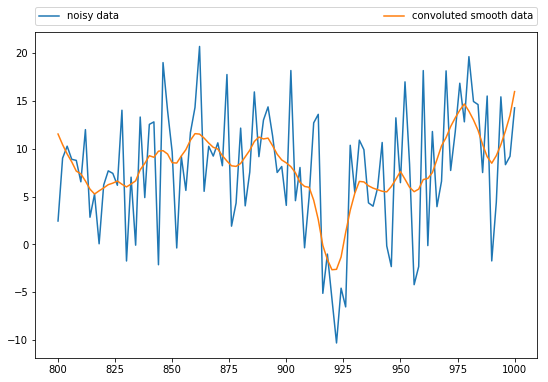

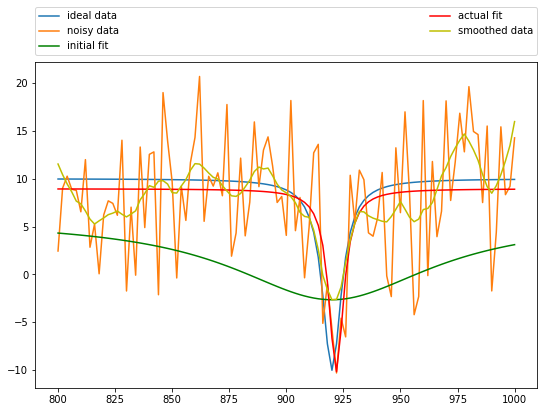

In [5]:
lorentziandip_testing()

In [6]:
def lorentziandip_testing2():
    """ Test the lorentzian fit directy with simulated data. """
    x_axis = np.linspace(800, 1000, 101)

    mod, params = fitlogic.make_lorentzian_model()
    print('Parameters of the model',mod.param_names)
    params = Parameters()

    params.add('amplitude',value=-10.)
    params.add('center',value=920.)
    params.add('sigma',value=5)
    params.add('offset', value=20.)

    data_nice = mod.eval(x=x_axis,params=params)
    data_noisy = data_nice + 2.0*np.random.normal(size=x_axis.shape)
    
    print(fitlogic.estimate_lorentzian_dip)

    result = fitlogic.make_lorentzian_fit(
        x_axis=x_axis,
        data=data_noisy,
        units=["MHz"],
        estimator=fitlogic.estimate_lorentzian_dip)

    plt.figure()
    plt.plot(x_axis, data_nice, label='ideal data')
    plt.plot(x_axis, data_noisy, label='noisy simulated data')
    plt.plot(x_axis, result.best_fit, '-r', label='actual fit')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

    print(result.fit_report())
    print(result.result_str_dict)

Parameters of the model ['amplitude', 'center', 'sigma', 'offset']
<bound method estimate_lorentzian_dip of <logic.fit_logic.FitLogic object at 0x7fa90f7a3438>>
[[Model]]
    ((Model(amplitude_function) * Model(physical_lorentzian)) + Model(constant_function))
[[Fit Statistics]]
    # function evals   = 38
    # data points      = 101
    # variables        = 4
    chi-square         = 427.755
    reduced chi-square = 4.410
    Akaike info crit   = 153.786
    Bayesian info crit = 164.247
[[Variables]]
    amplitude:  -12.5266968 +/- 1.897738 (15.15%) (init=-7.017979)
    center:      920.027126 +/- 0.472463 (0.05%) (init= 918)
    sigma:       2.97682544 +/- 0.661709 (22.23%) (init= 6.27817)
    offset:      20.1579919 +/- 0.229064 (1.14%) (init= 20.36364)
    fwhm:        5.95365088 +/- 1.323420 (22.23%)  == '2*sigma'
    contrast:   -62.1425828 +/- 9.424132 (15.17%)  == '(amplitude/offset)*100'
[[Correlations]] (unreported correlations are <  0.100)
    C(amplitude, sigma)          

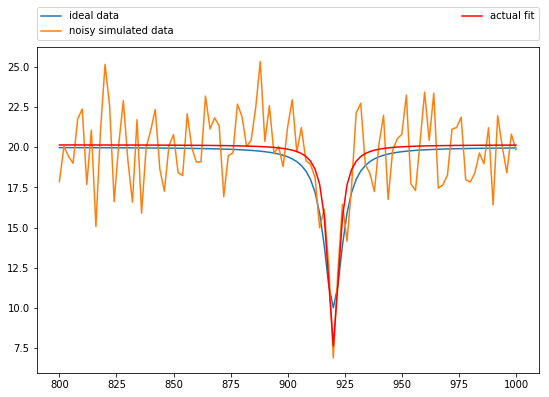

In [7]:
lorentziandip_testing2()

In [8]:
def double_lorentzpeak_testing2():
    """ Function to check the implemented double lorentz peak fit with offset. """
    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    
    x = np.linspace(start, stop, num_points)
    x_nice = np.linspace(start, stop, num_points*4)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
    p = Parameters()

    #============ Create data ==========
    p.add('l0_amplitude', value=abs(np.random.random(1)*2 + 40))
    p.add('l0_center', value=np.random.random(1)*150.0 + 2800)
    p.add('l0_sigma', value=abs(np.random.random(1)*1 + 1))
    
    p.add('l1_center', value=np.random.random(1)*150.0 + 2800)
    p.add('l1_sigma', value=abs(np.random.random(1)*4 + 1))
    p.add('l1_amplitude', value=abs(np.random.random(1)*1 + 50))

    p.add('offset',value=100.)

    data_noisy = (mod.eval(x=x, params=p) + 6 * np.random.normal(size=x.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentziandouble_peak)

    plt.figure()
    plt.plot(x, data_noisy,'o', label='noisy data')
    plt.plot(x, result.init_fit,'-y', label='initial fit')
    plt.plot(x, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x_nice, mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

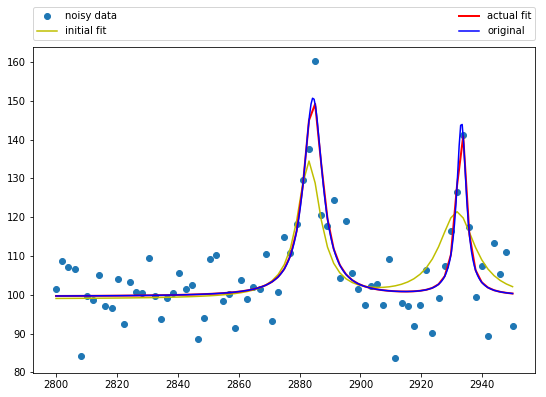

In [9]:
double_lorentzpeak_testing2()

In [10]:
def double_lorentzdip_testing():
    """ Test function to implement the estimator for the double lorentz dip
        fit with offset. """

    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x_axis = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    p=Parameters()

    #============ Create data ==========
    p.add('l0_amplitude',value=-abs(np.random.random(1)*2+20))
    p.add('l0_center',value=np.random.random(1)*150.0+2800)
    p.add('l0_sigma',value=abs(np.random.random(1)*1.+1.))
    p.add('l1_center',value=np.random.random(1)*150.0+2800)
    p.add('l1_sigma',value=abs(np.random.random(1)*4.+1.))
    p.add('l1_amplitude',value=-abs(np.random.random(1)*1+10))

    p.add('offset',value=100.)

    data_noisy = (mod.eval(x=x_axis,params=p) + 6 * np.random.normal(size=x_axis.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x_axis,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentziandouble_dip)

    data_smooth, offset = fitlogic.find_offset_parameter(x_axis, data_noisy)

    data_level = data_smooth - offset

    threshold_fraction = 0.3
    minimal_threshold =  0.01
    sigma_threshold_fraction = 0.3

    ret_val = fitlogic._search_double_dip(
        x_axis,
        data_level,
        threshold_fraction,
        minimal_threshold,
        sigma_threshold_fraction)

    error = ret_val[0]
    sigma0_argleft, dip0_arg, sigma0_argright = ret_val[1:4]
    sigma1_argleft, dip1_arg , sigma1_argright = ret_val[4:7]

    if dip0_arg == dip1_arg:
        lorentz0_amplitude = data_level[dip0_arg]/2.
        lorentz1_amplitude = lorentz0_amplitude
    else:
        lorentz0_amplitude = data_level[dip0_arg]
        lorentz1_amplitude = data_level[dip1_arg]

    lorentz0_center = x_axis[dip0_arg]
    lorentz1_center = x_axis[dip1_arg]


    smoothing_spline = 1    # must be 1<= smoothing_spline <= 5
    function = InterpolatedUnivariateSpline(
        x_axis,
        data_level,
        k=smoothing_spline)
    numerical_integral_0 = function.integral(
        x_axis[sigma0_argleft],
        x_axis[sigma0_argright])

    lorentz0_sigma = abs(numerical_integral_0 / (np.pi * lorentz0_amplitude))

    numerical_integral_1 = numerical_integral_0

    lorentz1_sigma = abs(numerical_integral_1 / (np.pi * lorentz1_amplitude))

    stepsize = x_axis[1]-x_axis[0]
    full_width = x_axis[-1]-x_axis[0]
    n_steps = len(x_axis)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

    if lorentz0_center < lorentz1_center:
        params['l0_amplitude'].set(value=lorentz0_amplitude, max=-0.01)
        params['l0_sigma'].set(value=lorentz0_sigma, min=stepsize/2, max=full_width*4)
        params['l0_center'].set(value=lorentz0_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
        params['l1_amplitude'].set(value=lorentz1_amplitude, max=-0.01)
        params['l1_sigma'].set(value=lorentz1_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l1_center'].set(value=lorentz1_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
    else:
        params['l0_amplitude'].set(value=lorentz1_amplitude, max=-0.01)
        params['l0_sigma'].set(value=lorentz1_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l0_center'].set(value=lorentz1_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)
        params['l1_amplitude'].set(value=lorentz0_amplitude, max=-0.01)
        params['l1_sigma'].set(value=lorentz0_sigma, min=stepsize/2,
                               max=full_width*4)
        params['l1_center'].set(value=lorentz0_center,
                                min=(x_axis[0])-n_steps*stepsize,
                                max=(x_axis[-1])+n_steps*stepsize)

    params['offset'].set(value=offset)

    result = mod.fit(data_noisy, x=x_axis, params=params)

    plt.figure()
    plt.plot(x_axis, data_noisy,'o', label='noisy data')
    plt.plot(x_axis, result.init_fit,'-y', label='initial fit')
    plt.plot(x_axis, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x_axis, data_smooth,'-g', label='smooth data')
    plt.plot(x_nice,mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)
    plt.show()

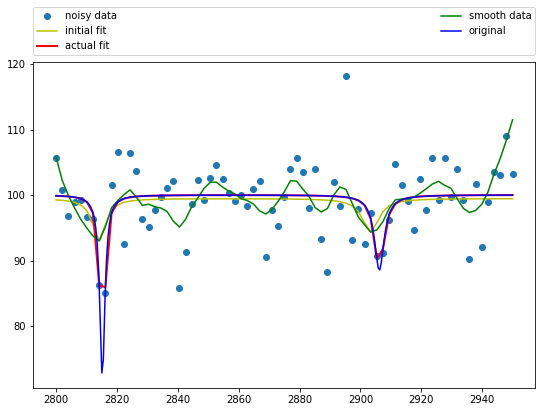

In [11]:
double_lorentzdip_testing()

In [12]:
def double_lorentzdip_testing2():
    """ Function to check the implemented double lorentz dip fit with offset. """
    start = 2800
    stop = 2950
    num_points = int((stop-start)/2)*1
    x = np.linspace(start, stop, num_points)

    x_nice = np.linspace(start, stop, num_points*4)

    mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)
    p = Parameters()

    #============ Create data ==========
    p.add('l0_amplitude', value=-abs(np.random.random(1)*2 + 30))
    p.add('l0_center', value=np.random.random(1)*150.0 + 2800)
    p.add('l0_sigma', value=abs(np.random.random(1)*1 + 1.))
    
    p.add('l1_center', value=np.random.random(1)*150.0 + 2800)
    p.add('l1_sigma', value=abs(np.random.random(1)*4 + 1))
    p.add('l1_amplitude', value=-abs(np.random.random(1)*1 + 40))

    p.add('offset',value=100.)

    data_noisy = (mod.eval(x=x,params=p) + 6*np.random.normal(size=x.shape))

    result = fitlogic.make_lorentziandouble_fit(
        x_axis=x,
        data=data_noisy,
        estimator=fitlogic.estimate_lorentziandouble_dip)

    data_smooth, offset = fitlogic.find_offset_parameter(x, data_noisy)
    data_level = data_smooth - offset

    plt.figure()
    plt.plot(x, data_noisy,'o', label='noisy data')
    plt.plot(x, result.init_fit,'-y', label='initial fit')
    plt.plot(x, result.best_fit,'-r', linewidth=2.0, label='actual fit')
    plt.plot(x, data_smooth,'-g', label='smooth data')
    plt.plot(x_nice,mod.eval(x=x_nice,params=result.params),'b',label='original')
    plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3, ncol=2, mode="expand", borderaxespad=0.)

    plt.show()
    print(result.fit_report())


[[Model]]
    (((Model(amplitude_function, prefix='l0_') * Model(physical_lorentzian, prefix='l0_')) + Model(constant_function)) + (Model(amplitude_function, prefix='l1_') * Model(physical_lorentzian, prefix='l1_')))
[[Fit Statistics]]
    # function evals   = 125
    # data points      = 75
    # variables        = 7
    chi-square         = 2279.146
    reduced chi-square = 33.517
    Akaike info crit   = 270.055
    Bayesian info crit = 286.278
[[Variables]]
    l0_amplitude:  -41.0322088 +/- 14.69940 (35.82%) (init=-36.50395)
    l0_center:      2900.25363 +/- 1.849778 (0.06%) (init= 2899.324)
    l0_sigma:       4.73209896 +/- 1.116946 (23.60%) (init= 4.763962)
    offset:         99.5127721 +/- 0.891977 (0.90%) (init= 100.3811)
    l1_amplitude:  -33.0724528 +/- 128.8450 (389.58%) (init=-36.78142)
    l1_center:      2904.28789 +/- 0.650677 (0.02%) (init= 2901.351)
    l1_sigma:       1.01351353 +/- 0.338445 (33.39%) (init= 4.728024)
    l0_fwhm:        9.46419793 +/- 2.233892 (2

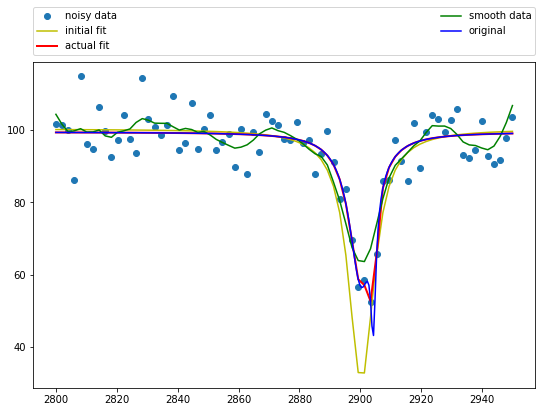

In [13]:
double_lorentzdip_testing2()

In [14]:
def double_lorentzian_fixedsplitting_testing():
    # This method does not work and has to be fixed!!!
    for ii in range(1):
        start=2800
        stop=2950
        num_points=int((stop-start)/2)
        x = np.linspace(start, stop, num_points)

        mod, params = fitlogic.make_multiplelorentzian_model(no_of_functions=2)

        p = Parameters()

        #============ Create data ==========
        p.add('offset',value=100)
        p.add('l0_amplitude', value=-abs(np.random.random(1)*50+100))
        p.add('l0_center', value=np.random.random(1)*150.0+2800)
        p.add('l0_sigma', value=abs(np.random.random(1)*2.+1.))
        p.add('l1_center', value=p['l0_center']+20)
        p.add('l1_sigma', value=abs(np.random.random(1)*2.+1.))
        p.add('l1_amplitude', value=-abs(np.random.random(1)*50+100))

        data_noisy = (mod.eval(x=x,params=p) + 2*np.random.normal(size=x.shape))

        para = Parameters()
        result = fitlogic.make_lorentziandouble_fit(
            x_axis=x,
            data=data_noisy,
            estimator=fitlogic.estimate_lorentziandouble_dip)


        data_smooth, offset = fitlogic.find_offset_parameter(x, data_noisy)
        data_level = data_smooth - offset

        #search for double lorentzian
        stuff = fitlogic._search_double_dip(x, data_level, make_prints=False)
        error, sigma0_argleft, dip0_arg, sigma0_argright, sigma1_argleft, dip1_arg , sigma1_argright = stuff
        
        print(
            x[sigma0_argleft],
            x[dip0_arg],
            x[sigma0_argright],
            x[sigma1_argleft],
            x[dip1_arg],
            x[sigma1_argright])
        print(x[dip0_arg], x[dip1_arg])

        plt.plot((x[sigma0_argleft], x[sigma0_argleft]), (data_noisy.min() ,data_noisy.max()), 'b-', label='sigma0')
        plt.plot((x[sigma0_argright], x[sigma0_argright]), (data_noisy.min() ,data_noisy.max()), 'b-', label='')

        plt.plot((x[sigma1_argleft], x[sigma1_argleft]), (data_noisy.min() ,data_noisy.max()), 'k-', label='sigma1')
        plt.plot((x[sigma1_argright], x[sigma1_argright]), (data_noisy.min() ,data_noisy.max()), 'k-', label='')

        plt.plot(x,data_noisy,'o', label='')
        plt.plot(x,result.init_fit,'-y', label='init fit')
        plt.plot(x,result.best_fit,'-r',linewidth=2.0, label='best fit')
        plt.plot(x,data_smooth,'-g', label='smooth data')
        plt.legend(bbox_to_anchor=(0, 1.02, 1, .102), loc=3, ncol=2, mode="expand", borderaxespad=0)
        plt.show()

2822.2972973 2830.40540541 2838.51351351 2842.56756757 2850.67567568 2856.75675676
2830.40540541 2850.67567568


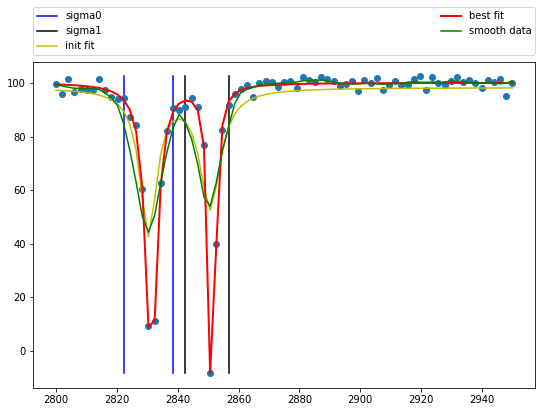

In [15]:
double_lorentzian_fixedsplitting_testing()